In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 clusters, so we need to change from the default color map so that they are all plotted with different colors
from cycler import cycler
tfcolor = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667), 
(0.8509803921568627, 0.37254901960784315, 0.00784313725490196), 
(0.4588235294117647, 0.4392156862745098, 0.7019607843137254), 
(0.9058823529411765, 0.1607843137254902, 0.5411764705882353), 
(0.4, 0.6509803921568628, 0.11764705882352941), 
(0.,         0.10980392, 0.94509804),
(0.6509803921568628, 0.4627450980392157, 0.11372549019607843), 
(0.,         0.89019608, 0.55490196),
(0.99037293, 0.44055363, 0.20318339),
(6.20005e-01, 1.83840e-01, 4.97524e-01)]
plt.rcParams['axes.prop_cycle'] = cycler('color', tfcolor)

import ligo.skymap.plot

from astropy.table import Table, QTable, vstack, join
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
sys.path.insert(1, '/global/homes/m/mjkeller/DESI_SGA/TF')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust

In [2]:
# cov_tfr, tfr_mcmc_samples, logV0
# w_y3v0p3
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_bgsy3v0p3.pickle', 'rb')
w_y3v0p3_cov_tfr, w_y3v0p3_tfr_mcmc_samples, w_y3v0p3_logV0 = pickle.load(temp_infile)
temp_infile.close()

temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_bgsy3wip.pickle', 'rb')
w_y3wip_cov_tfr, w_y3wip_tfr_mcmc_samples, w_y3wip_logV0 = pickle.load(temp_infile)
temp_infile.close()

temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tully.pickle', 'rb')
tully_y3_cov_tfr, tully_y3_tfr_mcmc_samples, tully_y3_logV0 = pickle.load(temp_infile)
temp_infile.close()

temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y3/cov_ab_jura_jointTFR_varyV0-perpdwarfs0_z0p1_tempely3.pickle', 'rb')
tempel_y3_cov_tfr, tempel_y3_tfr_mcmc_samples, tempel_y3_logV0 = pickle.load(temp_infile)
temp_infile.close()

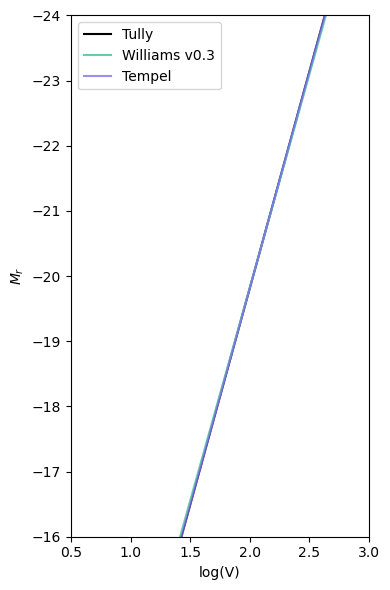

In [7]:
plt.figure(figsize=(4,6), tight_layout=True)
logv = np.arange(0, 3.5, 0.5)

# tully
slope = np.median(tully_y3_tfr_mcmc_samples[0])
ZP = np.median(tully_y3_tfr_mcmc_samples[1])
absmag = slope*(logv - tully_y3_logV0) + ZP

slopes = tully_y3_tfr_mcmc_samples[0]
ZPs = tully_y3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tully_y3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

plt.plot(logv, absmag, 'k', label = 'Tully')
plt.fill_between(logv, line_err[0], line_err[1], color='gainsboro', alpha = .25)

# williams v0.3
slope = np.median(w_y3v0p3_tfr_mcmc_samples[0])
ZP = np.median(w_y3v0p3_tfr_mcmc_samples[1])
absmag = slope*(logv - w_y3v0p3_logV0) + ZP

slopes = w_y3v0p3_tfr_mcmc_samples[0]
ZPs = w_y3v0p3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - w_y3v0p3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

plt.plot(logv, absmag, color='mediumaquamarine', label = 'Williams v0.3')
plt.fill_between(logv, line_err[0], line_err[1], color='lightcyan', alpha = .25)

# tempel
slope = np.median(tempel_y3_tfr_mcmc_samples[0])
ZP = np.median(tempel_y3_tfr_mcmc_samples[1])
absmag = slope*(logv - tempel_y3_logV0) + ZP

slopes = tempel_y3_tfr_mcmc_samples[0]
ZPs = tempel_y3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tempel_y3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

plt.plot(logv, absmag, color='mediumslateblue', label = 'Tempel', alpha = .75)
plt.fill_between(logv, line_err[0], line_err[1], color='lavender', alpha = .25)

plt.legend()
plt.xlim([0.5, 3])
plt.ylim([-16, -24])
plt.xlabel('log(V)')
plt.ylabel('$M_r$');

In [14]:
# cov_tfr, tfr_mcmc_samples, logV0
# williams y1v0p3
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y1/cov_ab_jura_jointTFR_bgsy1v0p3.pickle', 'rb')
w_y1v0p3_cov_tfr, w_y1v0p3_tfr_mcmc_samples, w_y1v0p3_logV0 = pickle.load(temp_infile)
temp_infile.close()

# tully
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y1/cov_ab_iron_jointTFR_tullyy1.pickle', 'rb')
tully_y1_cov_tfr, tully_y1_tfr_mcmc_samples, tully_y1_logV0 = pickle.load(temp_infile)
temp_infile.close()

# tempel
temp_infile = open('/global/homes/m/mjkeller/DESI_SGA/TF/Y1/cov_ab_jura_jointTFR_tempely1.pickle', 'rb')
tempel_y1_cov_tfr, tempel_y1_tfr_mcmc_samples, tempel_y1_logV0 = pickle.load(temp_infile)
temp_infile.close()

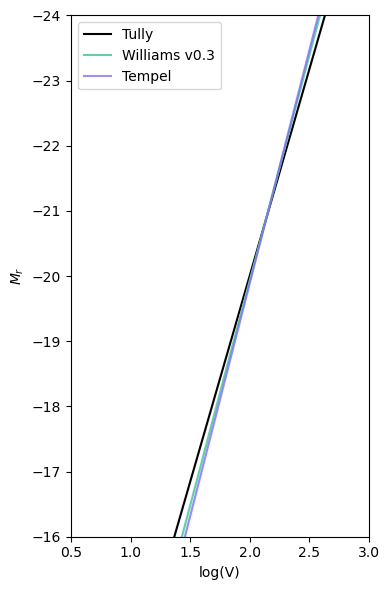

In [15]:
plt.figure(figsize=(4,6), tight_layout=True)
logv = np.arange(0, 3.5, 0.5)

# tully
slope = np.median(tully_y1_tfr_mcmc_samples[0])
ZP = np.median(tully_y1_tfr_mcmc_samples[1])
absmag = slope*(logv - tully_y1_logV0) + ZP

slopes = tully_y1_tfr_mcmc_samples[0]
ZPs = tully_y1_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tully_y1_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

plt.plot(logv, absmag, 'k', label = 'Tully')
plt.fill_between(logv, line_err[0], line_err[1], color='gainsboro', alpha = .25)

# williams v0.3
slope = np.median(w_y1v0p3_tfr_mcmc_samples[0])
ZP = np.median(w_y1v0p3_tfr_mcmc_samples[1])
absmag = slope*(logv - w_y1v0p3_logV0) + ZP

slopes = w_y1v0p3_tfr_mcmc_samples[0]
ZPs = w_y1v0p3_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - w_y1v0p3_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

plt.plot(logv, absmag, color='mediumaquamarine', label = 'Williams v0.3')
plt.fill_between(logv, line_err[0], line_err[1], color='lightcyan', alpha = .25)

# tempel
slope = np.median(tempel_y1_tfr_mcmc_samples[0])
ZP = np.median(tempel_y1_tfr_mcmc_samples[1])
absmag = slope*(logv - tempel_y1_logV0) + ZP

slopes = tempel_y1_tfr_mcmc_samples[0]
ZPs = tempel_y1_tfr_mcmc_samples[1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    lines.append(slopes[i]*(logv - tempel_y1_logV0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)

plt.plot(logv, absmag, color='mediumslateblue', label = 'Tempel', alpha = .75)
plt.fill_between(logv, line_err[0], line_err[1], color='lavender', alpha = .25)

plt.legend()
plt.xlim([0.5, 3])
plt.ylim([-16, -24])
plt.xlabel('log(V)')
plt.ylabel('$M_r$');